Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Entropy of diagnosis: 0.9526
Gini Index of diagnosis: 0.4675
Best root feature: area_mean_binned
Gains: {'radius_mean_binned': np.float64(0.4062304564282432), 'area_mean_binned': np.float64(0.49258655230085596), 'compactness_mean_binned': np.float64(0.2719823999422981)}


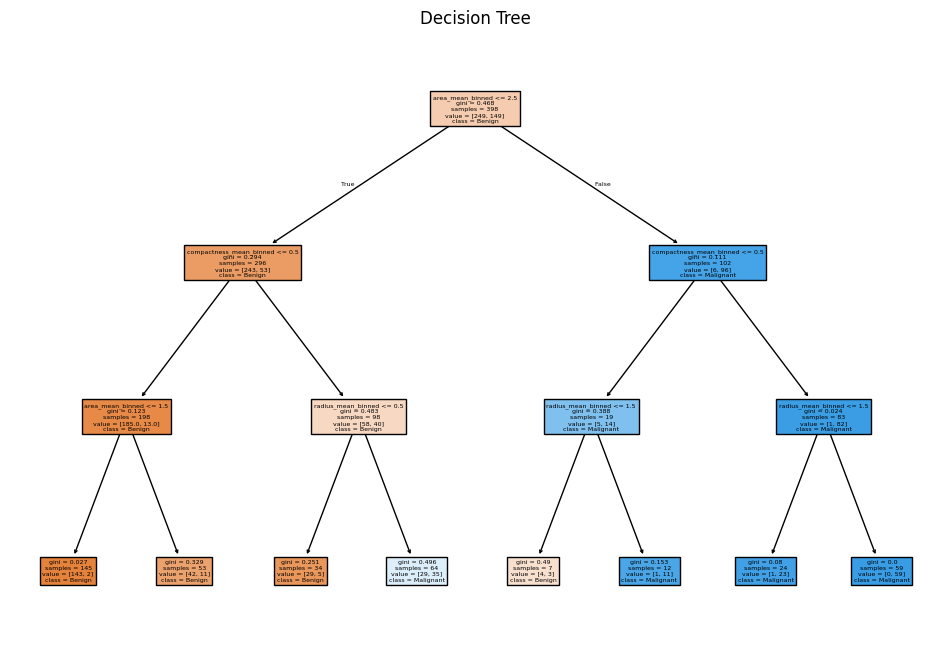

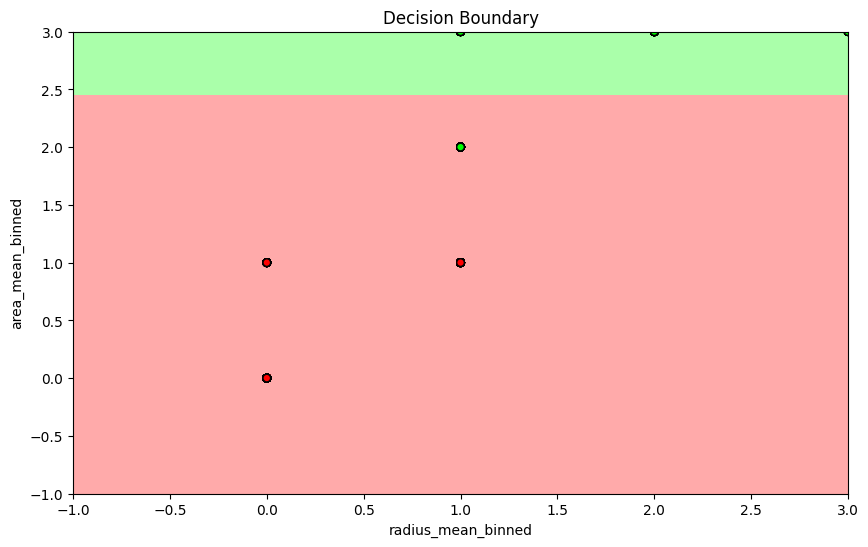

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import seaborn as sns
from matplotlib.colors import ListedColormap

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Cancer_Data.xlsx")
df = df.drop(columns=["id"])
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])  # M=1, B=0
df.head()

def calculate_entropy(y):
    counter = Counter(y)
    total = len(y)
    entropy = 0
    for count in counter.values():
        prob = count / total
        entropy -= prob * np.log2(prob)
    return entropy

# Example usage
entropy = calculate_entropy(df['diagnosis'])
print(f"Entropy of diagnosis: {entropy:.4f}")

def calculate_gini(y):
    counter = Counter(y)
    total = len(y)
    gini = 1.0
    for count in counter.values():
        prob = count / total
        gini -= prob ** 2
    return gini

# Example usage
gini = calculate_gini(df['diagnosis'])
print(f"Gini Index of diagnosis: {gini:.4f}")

def equal_width_binning(series, bins=4):
    return pd.cut(series, bins=bins, labels=False)

def frequency_binning(series, bins=4):
    return pd.qcut(series, q=bins, labels=False, duplicates='drop')

# Example binning
df['radius_mean_binned'] = equal_width_binning(df['radius_mean'])
df['area_mean_binned'] = frequency_binning(df['area_mean'])
df[['radius_mean', 'radius_mean_binned', 'area_mean', 'area_mean_binned']].head()

def information_gain(df, feature, target):
    total_entropy = calculate_entropy(df[target])
    values = df[feature].unique()
    weighted_entropy = 0
    for val in values:
        subset = df[df[feature] == val][target]
        weighted_entropy += (len(subset) / len(df)) * calculate_entropy(subset)
    return total_entropy - weighted_entropy

# Root node selection
def best_split(df, features, target):
    gains = {feature: information_gain(df, feature, target) for feature in features}
    return max(gains, key=gains.get), gains

# Apply on binned features
df['compactness_mean_binned'] = equal_width_binning(df['compactness_mean'])
feature_cols = ['radius_mean_binned', 'area_mean_binned', 'compactness_mean_binned']
root, gains = best_split(df, feature_cols, 'diagnosis')
print("Best root feature:", root)
print("Gains:", gains)

X = df[feature_cols]
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=feature_cols, class_names=["Benign", "Malignant"], filled=True)
plt.title("Decision Tree")
plt.show()

# Use only 2 features for boundary
features = ['radius_mean_binned', 'area_mean_binned']
X = df[features].values
y = df['diagnosis'].values

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=30)
plt.xlabel('radius_mean_binned')
plt.ylabel('area_mean_binned')
plt.title('Decision Boundary')
plt.show()
